# Spotify Rec Sys


- Since we have song features, let’s focus on content-based filtering.
- Compute similarity between songs using techniques like cosine similarity.
- And then make it dyanmic by adding user data
- Recommend songs similar to those a user has already liked and then use collaborative filtering and then use hybrid model





In [1]:
file_path = 'spotify_data/train.csv'
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#turn into a pandas dataframe
data = pd.read_csv(file_path)
data.shape

(129172, 19)

In [2]:
# I wanna only take a smaller subset of the data to make it easier to work with
data = data.sample(frac=0.05, random_state=1)
data.shape

(6459, 19)

In [3]:
data

,id,artists,name,year,acousticness,danceability,duration_ms,energy,explicit,instrumentalness,key,liveness,loudness,mode,release_date,speechiness,tempo,valence,popularity
105706,5ecmXyYSyzVH0YW6L9JFWI,['Workout Music '],Bad Liar (Cardio + Running Workout Mix),2020,0.015500,0.546,220532,0.885,0,0.000249,8,0.1110,-4.818,1,2020-12-23,0.1710,160.053,0.630,7
43634,5L0R973DXyyHBCusBp0xbp,"['Gene Kelly', 'Debbie Reynolds', ""Donald O'Co...",Main Title (Singin' In The Rain),1952,0.856000,0.268,103280,0.433,0,0.032500,7,0.1810,-10.226,0,1952-04-11,0.0352,75.933,0.372,8
92308,7Ll2qd2GHRl4iX2HZYgS9W,['Antonio Aguilar'],La Recién Casada,1988,0.530000,0.662,140557,0.408,0,0.000007,5,0.1500,-8.881,1,1988-01-01,0.0820,126.056,0.956,38
41407,3DytidwwDXv5gZVilj2lO1,['ABBA'],Lovelight,1979,0.111000,0.559,228133,0.720,0,0.000105,0,0.3280,-5.948,1,1979,0.0302,125.139,0.683,25
95655,08Px3e9b35UkrpFlRkxH3l,['Andrea Bocelli'],The Power Of Love,1995,0.524000,0.540,306456,0.599,0,0.001210,3,0.0692,-7.132,1,1995-01-01,0.0359,138.079,0.292,51
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43985,50qma2LfxTfAILyNlZEnpP,"[""Guns N' Roses""]",Sweet Child O' Mine,1987,0.090100,0.446,356067,0.952,0,0.085700,6,0.1120,-5.321,1,1987-07-29,0.0523,125.303,0.624,42
27597,7MUO72DucIUaSVlPho4Sx3,['YELLOW MAGIC ORCHESTRA'],ファイアークラッカー,1979,0.167000,0.707,292507,0.964,0,0.515000,2,0.0612,-2.046,1,1979,0.0379,119.938,0.971,30
9806,7KGbYZv593eAMISQjYqTDT,['AC/DC'],I Put the Finger on You,1981,0.000167,0.483,205707,0.980,0,0.664000,9,0.1690,-4.033,1,1981-11-23,0.0632,133.816,0.759,40
129087,0lzhlzzrCSRSmm7TDpAG8f,['K-Rino'],The Set Up,2003,0.170000,0.696,275120,0.837,1,0.000000,1,0.0618,-9.426,0,2003-06-29,0.2320,158.846,0.873,2


# Data Preprocessing
## Check for missing values

In [4]:
# Check for missing values coded as NA or -1 or empty string
missing_values = data.isin(['NA', -1, ''])
if missing_values.any().any():
    print("Missing values detected:")
    print(data[missing_values.any(axis=1)])
else:
    print("No missing values detected.")

No missing values detected.


 ## Normalize
Next we will normalize our data using min,max normalization  $X_n = \frac{x-min_x}{max_x-min_x}$

In [5]:
# drop columns with categorical data
non_categorical_columns = ['acousticness', 'danceability', 'duration_ms', 'energy', 'instrumentalness', 'key', 'liveness', 'loudness', 'mode', 'speechiness', 'tempo', 'valence', 'popularity']
df_non_categorical = data[non_categorical_columns]
norm_data = (df_non_categorical-df_non_categorical.min())/(df_non_categorical.max()-df_non_categorical.min())
norm_data.head()

,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,valence,popularity
105706,0.015561,0.560000,0.085064,0.885867,0.000250,0.727273,0.096085,0.868600,1.0,0.176107,0.726879,0.634441,0.074468
43634,0.859438,0.274872,0.036840,0.433340,0.032598,0.636364,0.167260,0.739209,0.0,0.036251,0.344849,0.374622,0.085106
92308,0.532128,0.678974,0.052172,0.408311,0.000007,0.454545,0.135740,0.771390,1.0,0.084449,0.572482,0.962739,0.404255
41407,0.111445,0.573333,0.088190,0.720675,0.000105,0.000000,0.316726,0.841564,1.0,0.031102,0.568318,0.687815,0.265957
95655,0.526104,0.553846,0.120403,0.599534,0.001214,0.272727,0.053584,0.813236,1.0,0.036972,0.627085,0.294058,0.542553


## Pearson Correlation 

In [6]:
def highly_correlated_features(df, threshold):
    correlation_matrix = df.corr() # Calculate the correlation matrix
    
    features_to_drop = set()
    highly_correlated_pairs = []
    
    for i in range(correlation_matrix.shape[0]):
        for j in range(i+1, correlation_matrix.shape[1]):
            # If the absolute value of the correlation coefficient is above the threshold, add the feature to the set
            if abs(correlation_matrix.iloc[i, j]) > threshold:
                features_to_drop.add(correlation_matrix.columns[j])
                highly_correlated_pairs.append((correlation_matrix.columns[i], correlation_matrix.columns[j], correlation_matrix.iloc[i, j]))

    return features_to_drop , highly_correlated_pairs

In [7]:
drop_features, correlated_pairs  = highly_correlated_features(norm_data, 0.7)


print("We can drop these Features:",drop_features)
print()
print("Correlated Pairs and their coefficient")
for i in correlated_pairs:
    print(i)

We can drop these Features: {'loudness', 'energy'}

Correlated Pairs and their coefficient
('acousticness', 'energy', -0.7479453244198077)
('energy', 'loudness', 0.7834599300783284)


In [8]:
filtered_data = norm_data.drop(columns=drop_features)
filtered_data.head()

,acousticness,danceability,duration_ms,instrumentalness,key,liveness,mode,speechiness,tempo,valence,popularity
105706,0.015561,0.560000,0.085064,0.000250,0.727273,0.096085,1.0,0.176107,0.726879,0.634441,0.074468
43634,0.859438,0.274872,0.036840,0.032598,0.636364,0.167260,0.0,0.036251,0.344849,0.374622,0.085106
92308,0.532128,0.678974,0.052172,0.000007,0.454545,0.135740,1.0,0.084449,0.572482,0.962739,0.404255
41407,0.111445,0.573333,0.088190,0.000105,0.000000,0.316726,1.0,0.031102,0.568318,0.687815,0.265957
95655,0.526104,0.553846,0.120403,0.001214,0.272727,0.053584,1.0,0.036972,0.627085,0.294058,0.542553


/Users/syedalihaider/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/syedalihaider/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/syedalihaider/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/syedalihaider/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The 

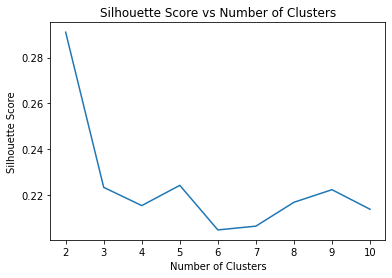

In [9]:
# Compute clsuters to do unsupervised learning
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Create a list to store the silhouette scores
silhouette_scores = []

# Create a list of different number of clusters to try
n_clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10]

# Loop through each cluster
for n in n_clusters:
    # Create a KMeans object with n clusters and fit it to the data
    kmeans = KMeans(n_clusters=n, random_state=0)
    kmeans.fit(filtered_data)
    
    # Calculate the silhouette score and append it to the list
    silhouette_scores.append(silhouette_score(filtered_data, kmeans.labels_))

# Plot the silhouette scores
plt.plot(n_clusters, silhouette_scores)
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs Number of Clusters')
plt.show()

In [10]:
# compute cosine similarity with all the songs
from sklearn.metrics.pairwise import cosine_similarity

# Calculate the cosine similarity matrix
cosine_similarity_matrix = cosine_similarity(filtered_data)

# Create a DataFrame for the cosine similarity matrix
cosine_similarity_df = pd.DataFrame(cosine_similarity_matrix, index=filtered_data.index, columns=filtered_data.index)
cosine_similarity_df.head()

,105706,43634,92308,41407,95655,27270,17508,33301,63587,103957,...,712,67178,47414,16379,101198,43985,27597,9806,129087,48222
105706,1.000000,0.555472,0.906315,0.873521,0.843990,0.554309,0.897238,0.928698,0.676203,0.690007,...,0.952099,0.600927,0.615195,0.822571,0.927312,0.957195,0.861800,0.907008,0.691723,0.805021
43634,0.555472,1.000000,0.684201,0.419737,0.604295,0.524245,0.451861,0.585989,0.739554,0.648611,...,0.676374,0.574105,0.666488,0.570249,0.517495,0.540226,0.483914,0.536843,0.587771,0.783210
92308,0.906315,0.684201,1.000000,0.924548,0.921228,0.660769,0.946400,0.918958,0.769708,0.622950,...,0.925099,0.790513,0.630682,0.762287,0.855717,0.946440,0.925033,0.865131,0.752223,0.865015
41407,0.873521,0.419737,0.924548,1.000000,0.884565,0.617947,0.966911,0.863623,0.631341,0.450338,...,0.848335,0.760989,0.511236,0.702777,0.857277,0.915613,0.924478,0.813773,0.703312,0.718256
95655,0.843990,0.604295,0.921228,0.884565,1.000000,0.713573,0.889163,0.931380,0.748961,0.592844,...,0.882110,0.887600,0.530725,0.768668,0.789132,0.917233,0.839422,0.801078,0.580598,0.870542


# Collab filtering with cosine similarity

In [11]:
data_new = data.drop(columns=drop_features)
data_new.head()

# Create a function to get recommendations based on the cosine similarity matrix
def get_recommendations(song_title, cosine_similarity_df, data):
    # Get the index of the song
    song_index = data[data['name'] == song_title].index[0]
    
    # Get the similarity scores of the song
    similarity_scores = cosine_similarity_df[song_index]
    
    # Get the indices of the songs with the highest similarity scores
    similar_songs = similarity_scores.sort_values(ascending=False).index[1:6]
    
    # return like this: Index: 1, Name: 'song name', Artists: 'artist name'
    recommended_songs = []
    for i in similar_songs:
        recommended_songs.append({'Index': i, 'Name': data['name'][i], 'Artists': data['artists'][i]})
    
    return recommended_songs

## Test the function

In [12]:
# Get recommendations for the song 'SLovelight' by ABBA
song = 'The Set Up'
recommendations = get_recommendations(song, cosine_similarity_df, data_new)
#fix the print statement print(f"Since you listened to {},you might also like:") # fix this, make it f%
print(f"Since you listened to {song}, you might also like:")
for i in recommendations:
    print('Index:', i['Index'], 'Name:', i['Name'], ' By:', i['Artists'])


Since you listened to The Set Up, you might also like:
Index: 24905 Name: Achtung  By: ['Illinois Jacquet']
Index: 56704 Name: We Are Not Separate  By: ['Kamelot']
Index: 70457 Name: Ten years look young 2017  By: ['Two Hundred Road']
Index: 37307 Name: I Can Make It Better  By: ['The Whispers']
Index: 50698 Name: If You're Not Scared  By: ["K's Choice"]


- we need to make the user sign up on our database first before we can recommend songs to them
- we can use the user's listening history to recommend songs to them
- we can also add a feature to allow the user to rate the recommended songs
- we can also add a feature to allow the user to search for songs and artists

# Create user profile

In [13]:
def generate_unique_user_id(user_data):
    while True:
        user_id = np.random.randint(100000, 999999)
        if user_id not in user_data['user_id'].values:
            return user_id

def user_signup(user_data, user_name, user_email, user_password):
    user_id = generate_unique_user_id(user_data)
    new_user = pd.DataFrame({'user_id': [user_id], 'user_name': [user_name], 'user_email': [user_email], 'user_password': [user_password]})
    user_data = pd.concat([user_data, new_user], ignore_index=True)
    print("User signed up successfully!")
    return user_data

def user_login(user_data, user_email, user_password):
    user = user_data[(user_data['user_email'] == user_email) & (user_data['user_password'] == user_password)]
    if user.empty:
        print("Invalid email or password. Please try again.")
        return None
    else:
        print("User logged in successfully!")
        return user.iloc[0]['user_id']

def add_to_database(user_data, user_id, user_name, user_email, user_password):
    new_user = pd.DataFrame({'user_id': [user_id], 'user_name': [user_name], 'user_email': [user_email], 'user_password': [user_password]})
    user_data = pd.concat([user_data, new_user], ignore_index=True)
    return user_data

def rate_song(user_id, song_index, rating, ratings_data):
    new_rating = pd.DataFrame({'user_id': [user_id], 'song_index': [song_index], 'rating': [rating]})
    ratings_data = pd.concat([ratings_data, new_rating], ignore_index=True)
    print("Song rated successfully!")
    return ratings_data

def search_song(song_name, data):
    search_results = data[data['name'].str.contains(song_name, case=False)]
    if search_results.empty:
        print("No matching songs found.")
    else:
        print("Matching songs found:")
        print(search_results[['name', 'artists']])
    return search_results

## Test user profile

In [14]:
# Initialize user data
user_data = pd.DataFrame(columns=['user_id', 'user_name', 'user_email', 'user_password'])

# sign up 
user_name = "John Doe"
user_email = "john@example.com"
user_password = "password123"
user_data = user_signup(user_data, user_name, user_email, user_password)

User signed up successfully!


In [15]:
# Log in 
user_email = "john@example.com"
user_password = "password123"
user_id = user_login(user_data, user_email, user_password)

User logged in successfully!


In [16]:
user_data

,user_id,user_name,user_email,user_password
0,935550,John Doe,john@example.com,password123


In [17]:
# # Initialize ratings data
ratings_data = pd.DataFrame(columns=['user_id', 'song_index', 'rating'])

# Rate a song
user_id = user_data[user_data['user_email'] == user_email]['user_id'].values[0] 
song_index = 247933
rating = 5 
ratings_data = rate_song(user_id, song_index, rating, ratings_data)

Song rated successfully!


In [18]:
ratings_data

,user_id,song_index,rating
0,935550,247933,5


In [19]:
# search for a song
song_name = "The Set Up" 
search_results = search_song(song_name, data)

Matching songs found:
              name     artists
129087  The Set Up  ['K-Rino']
